# Self Organizing Maps
unsupervised learning method  
https://sci2s.ugr.es/keel/pdf/algorithm/articulo/1990-Kohonen-PIEEE.pdf  
http://www.cs.bham.ac.uk/~jxb/NN/l16.pdf
- import libraries

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
import math
from pylab import bone, pcolor, colorbar, plot, show

- read the dataset

In [4]:
dataset = pd.read_csv('datasets/Credit_Card_Applications.csv')
dataset.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [5]:
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:, -1].values

- feature scaling

In [7]:
scaler   = MinMaxScaler() # default range is (0,1)
X_scaled = scaler.fit_transform(X)

- train the SOM

In [15]:
mapSize = math.ceil(math.sqrt(5*math.sqrt(len(X)))) # rule of thumb

In [44]:
som = MiniSom(x=mapSize,y=mapSize, input_len=15, sigma=1.0, learning_rate=.5)
som.random_weights_init(X_scaled)
som.train_random(X_scaled, 96) # data, iterations

- visualize the map (with pylab, not matplotlib)
- use mean inter-neuron distance (MID)
- add markers to identify fraud

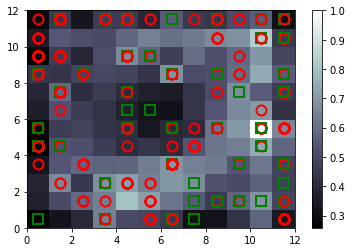

In [45]:
markers = ['o', 's'] # circle, square
colors  = ['r', 'g'] # red is no approval, green is approval
mid_map = som.distance_map()
bone() # creates an empty canvas
pcolor(mid_map.T)
colorbar() # higher number is correlated to outliers

for i,x in enumerate(X_scaled):
    node = som.winner(x)
    plot(node[0]+.5, node[1]+.5, markers[y[i]], markeredgecolor=colors[y[i]], markerfacecolor='None', markersize=10, markeredgewidth=2)  

- detect the frauds, (10,10) and (10,5)

In [50]:
mappings = som.win_map(X_scaled)
frauds   = np.concatenate((mappings[(10,5)], mappings[(10,10)]), axis=0)


[]